In [1]:
import datetime as dt
today = dt.datetime.now() 
print('This notebook was last updated on', today.strftime('%A %B %D at %H:%M'))

This notebook was last updated on Monday July 07/06/20 at 11:44


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib import ticker
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

In [3]:
# load into a dataframe:
pop = pd.read_excel('../data/county_pops.xlsx', comment='#', header=1)

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

pop.columns = np.append(np.array(['county']), pop.columns[1:].values)
pop.county = pop.county.str.strip('.')
pop.county = pop.county.str.split('County,', expand=True)[0].str.strip()

cases = df.groupby('county').cases.apply(max).sum()
df = df[df.cases > 5]

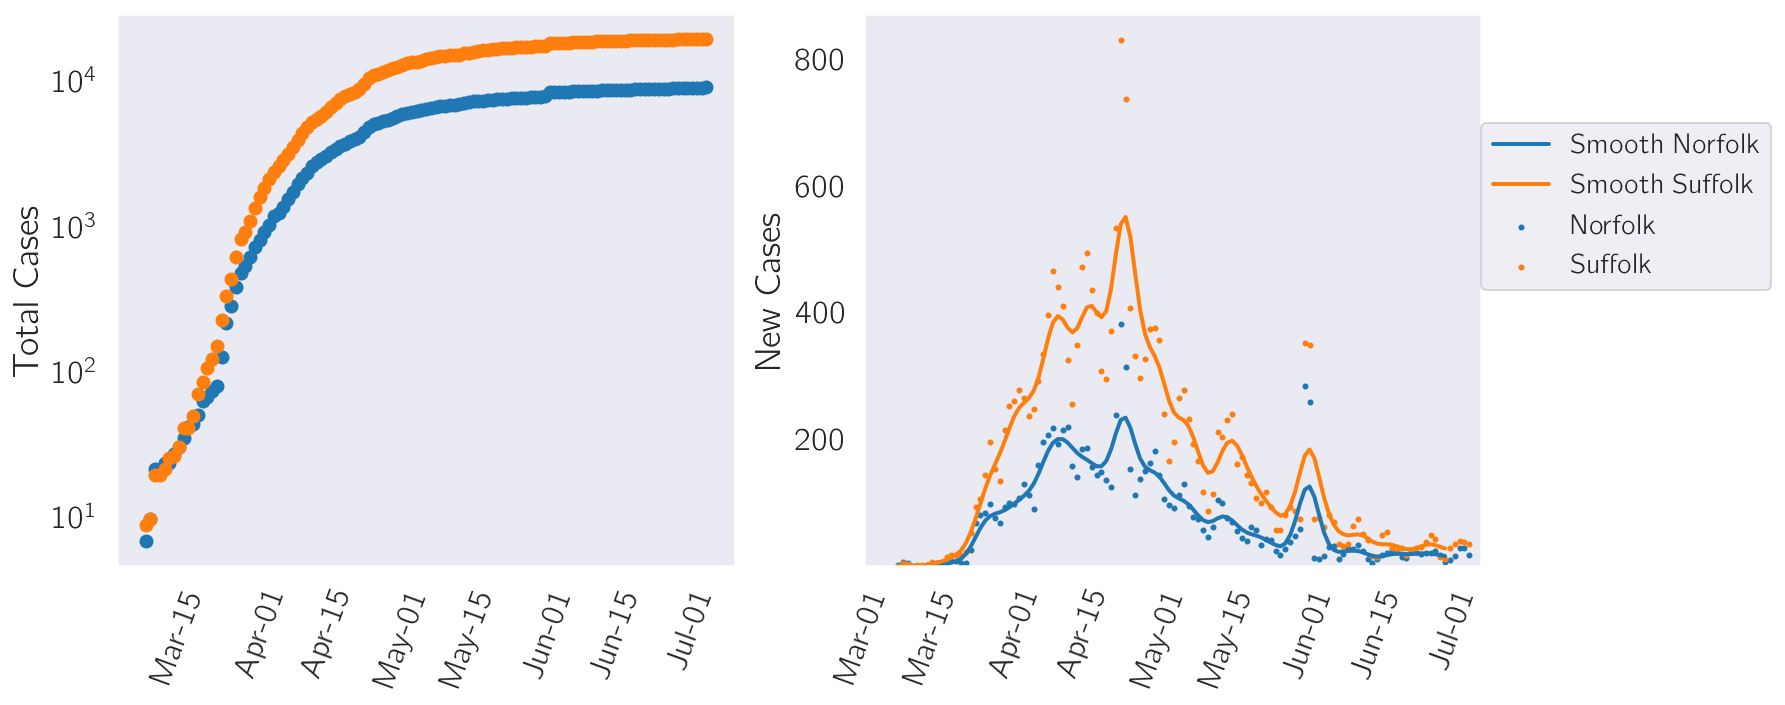

In [7]:
def plot_county_cases(df, cond, ax):
    suff = df[cond]

    for n, g in suff.groupby('county'):
        ax.plot(g.date, g.cases, 'o', label=n)

    ax.set_yscale('log')
    date_form = DateFormatter("%b-%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel('Total Cases')

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
    return ax

def plot_new_cases(df, cond, ax):
    suff = df[cond]
    currmax = 0
    for n, g in suff.groupby('county'):
        ax.scatter(g.date, np.gradient(g.cases),
                   label=n, s=4)
        ax.plot(g.date,
                 np.gradient(g.cases.rolling(win_type='gaussian',
                                             window=10,
                                             center=True).mean(std=2)),
                 label='Smooth ' + n)
        if np.gradient(g.cases).max() > currmax:
            currmax = np.gradient(g.cases).max()

    ax.set_ylim(1, currmax * 1.05)
    date_form = DateFormatter("%b-%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel('New Cases')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
    return ax

fig, ax = plt.subplots(ncols=2, figsize=(12.5, 5))
cond = (((df.county == 'Suffolk') & (df.fips == 25025)) | (df.county == 'Norfolk'))
plot_county_cases(df, cond, ax[0])
plot_new_cases(df, cond, ax[1])
plt.xlim(dt.datetime(2020, 3, 1), dt.datetime.now())
_ = plt.legend(loc=(1, 0.5))
plt.tight_layout()

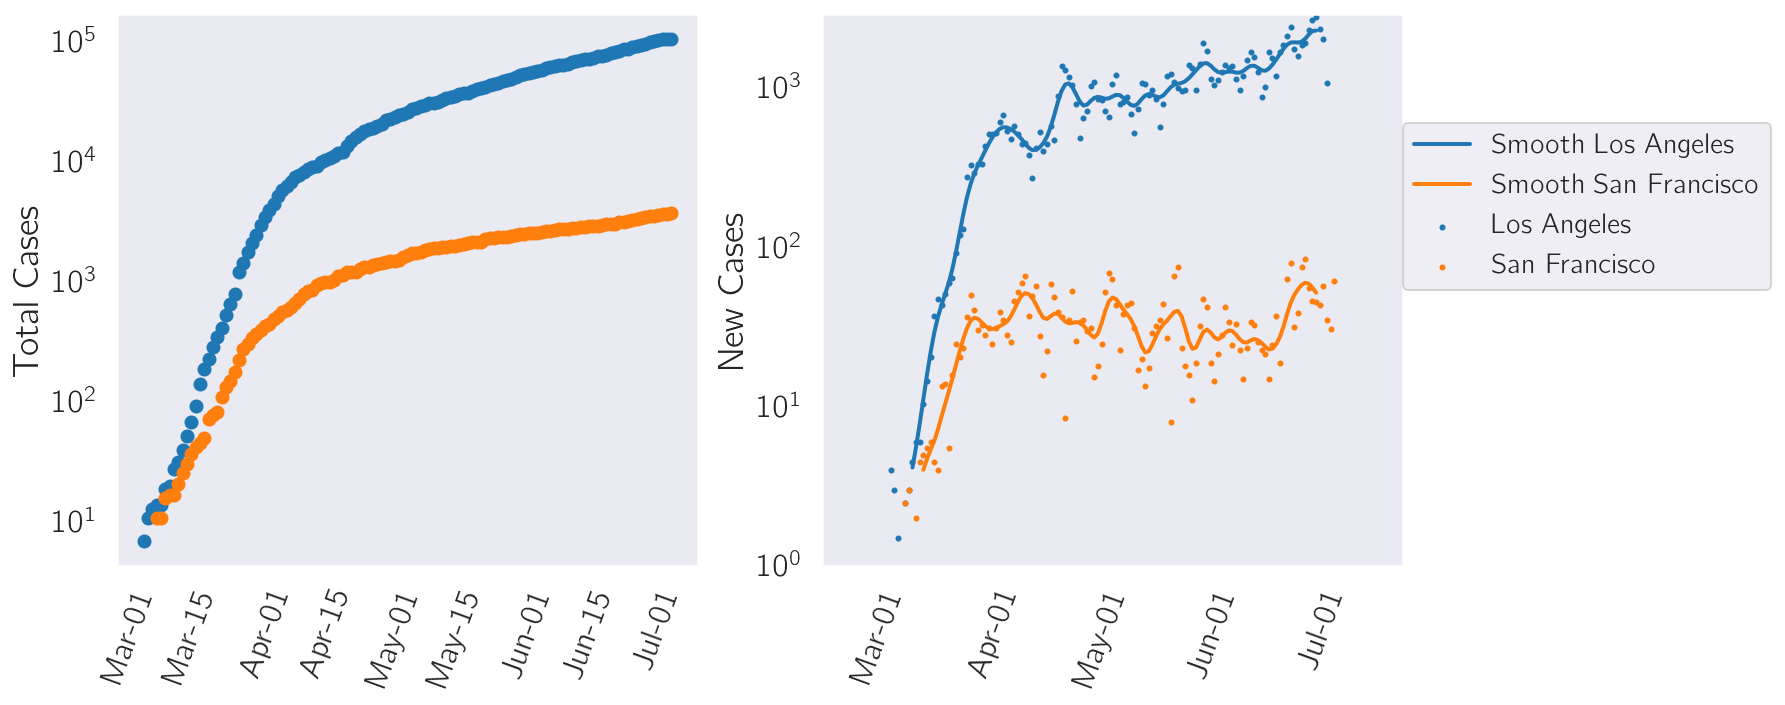

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(12.5, 5))
cond = (df.county == "Los Angeles") | (df.county == 'San Francisco')
plot_county_cases(df, cond, ax[0])
plot_new_cases(df, cond, ax[1])
_ = plt.legend(loc=(1, 0.5))
ax[1].set_yscale('log')
plt.tight_layout()

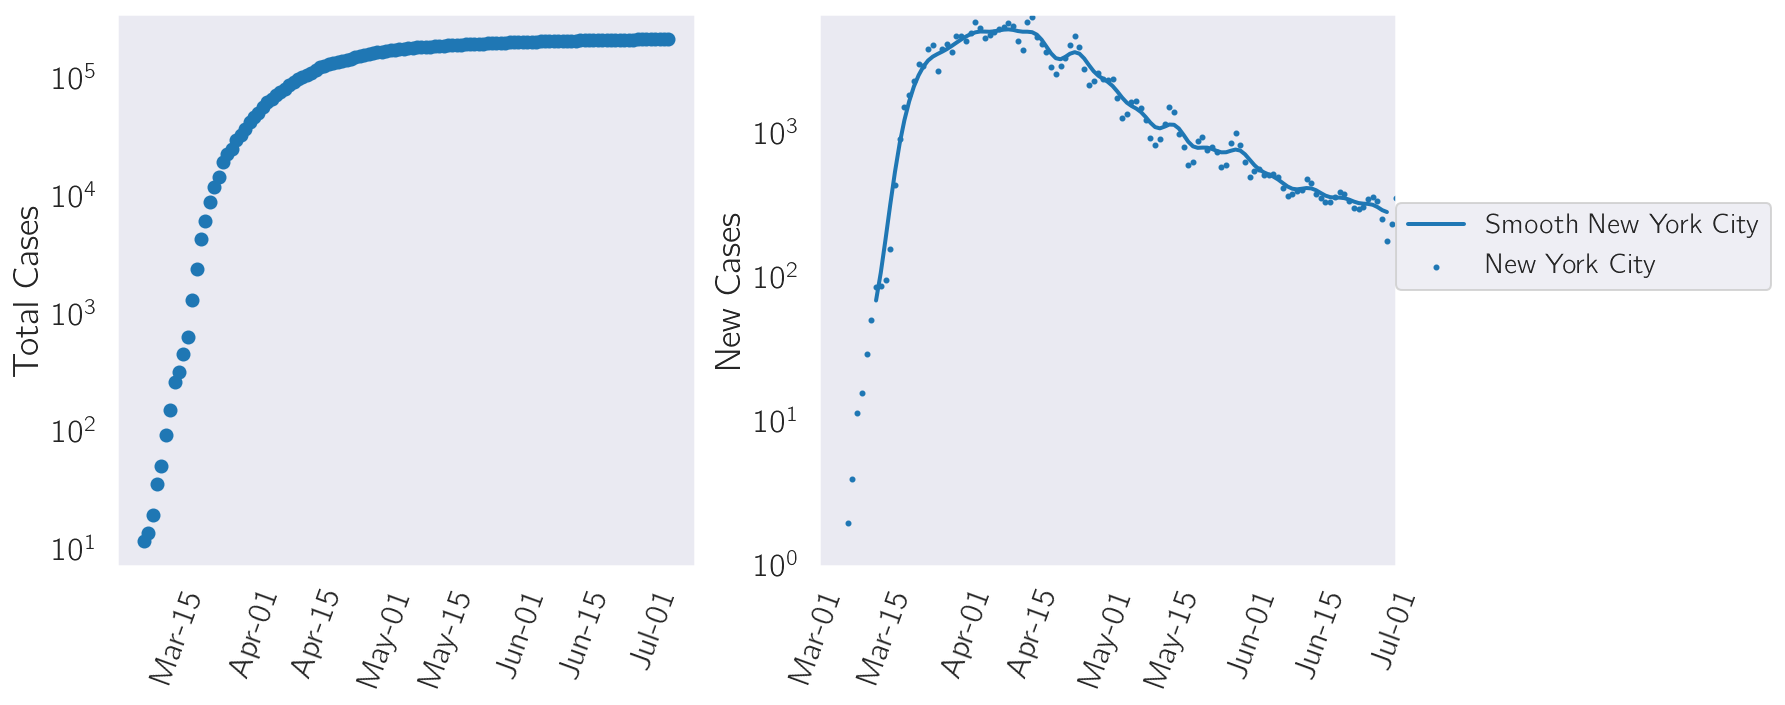

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(12.5, 5))
cond = (df.county == 'New York City')
plot_county_cases(df, cond, ax[0])
plot_new_cases(df, cond, ax[1])
plt.xlim(dt.datetime(2020, 3, 1), dt.datetime(2020, 7, 1))
_ = plt.legend(loc=(1, 0.5))
plt.yscale('log')
plt.tight_layout()
